In [2]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


In [3]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [4]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [5]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [6]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c544b2630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt.
INFO:tensorflow:loss = 2.3105807, step = 1
INFO:tensorflow:global_step/sec: 1.64067
INFO:tensorflow:loss = 0.6437336, step = 101 (60.952 sec)
INFO:tensorflow:global_step/sec: 1.12627
INFO:tensorflow:loss = 0.50321627, step = 201 (88.793 sec)
INFO:tensorflow:global_step/sec: 1.12046
INFO:tensorflow:loss = 0.544033, step = 301 (89.245 sec)
INFO:tensorflow:global_step/sec: 1.17804
INFO:tensorflow:loss = 0.42035416, step = 401 (84.887 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7663883.


In [8]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-28-05:26:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-28-05:26:53
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.8321, global_step = 500, loss = 0.46593684
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500


{'accuracy': 0.8321, 'loss': 0.46593684, 'global_step': 500}

In [9]:
write = 1
if write==1:
    f = open("results/rotate.txt", 'w')

# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []

angle = 0.0
accMat = []
for s in range(0,100):
    X_test = X_test_backup
    y_test = Y_test_backup
    angle = angle+0.5
    datagen = ImageDataGenerator(rotation_range=angle)# fit parameters from data
    datagen.fit(X_test)
    tmp = []
    # configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=n_images, shuffle=False):
        tmp = X_batch
        yTemp = y_batch
        break
    y_test = yTemp
    X_test = tmp
    x_te={'images': tmp}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
                accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(tmp[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
    print("Model accuracy:", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    accMat.append(accuracy)
    if write==1:
        f.write(str(angle)+"\t"+str(accuracy)+"\n")
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8305999999999248
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.828899999999925
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op

INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.756299999999933
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7497999999999337
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7437999999999344
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
IN

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.6132999999999488
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.6064999999999495
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5990999999999503
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.48839999999996253
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4851999999999629
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.475099999999964
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.40359999999997187
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4051999999999717
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmprn020bxb/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.3887999999999735
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn

In [10]:
yTotal = [0]*10

for y in y_test:
    yTotal[y] = yTotal[y]+1

aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*10 for i in range(10)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    



Ymatrix for rotation 0
0.856000 0.002000 0.027000 0.038000 0.007000 0.005000 0.053000 0.000000 0.012000 0.000000 
0.006000 0.949000 0.000000 0.032000 0.009000 0.001000 0.001000 0.000000 0.002000 0.000000 
0.016000 0.000000 0.804000 0.008000 0.154000 0.000000 0.015000 0.000000 0.003000 0.000000 
0.032000 0.004000 0.020000 0.872000 0.054000 0.000000 0.015000 0.000000 0.003000 0.000000 
0.005000 0.003000 0.157000 0.043000 0.758000 0.000000 0.032000 0.000000 0.002000 0.000000 
0.000000 0.000000 0.000000 0.001000 0.000000 0.933000 0.000000 0.050000 0.001000 0.015000 
0.244000 0.001000 0.218000 0.049000 0.189000 0.000000 0.279000 0.000000 0.020000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.006000 0.000000 0.950000 0.001000 0.043000 
0.001000 0.001000 0.015000 0.005000 0.011000 0.007000 0.009000 0.004000 0.946000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.007000 0.000000 0.033000 0.001000 0.959000 


Ymatrix for rotation 1
0.859000 0.002000 0.029000 0.037000 0.00

0.002000 0.000000 0.196000 0.040000 0.734000 0.001000 0.021000 0.000000 0.006000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.893000 0.000000 0.083000 0.003000 0.021000 
0.266000 0.002000 0.275000 0.045000 0.232000 0.000000 0.158000 0.000000 0.022000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.006000 0.000000 0.933000 0.002000 0.059000 
0.002000 0.001000 0.014000 0.007000 0.011000 0.008000 0.009000 0.005000 0.942000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.006000 0.000000 0.046000 0.002000 0.946000 


Ymatrix for rotation 15
0.852000 0.000000 0.032000 0.038000 0.014000 0.005000 0.044000 0.000000 0.015000 0.000000 
0.023000 0.865000 0.001000 0.099000 0.010000 0.000000 0.000000 0.000000 0.002000 0.000000 
0.014000 0.000000 0.752000 0.005000 0.203000 0.001000 0.021000 0.000000 0.004000 0.000000 
0.048000 0.005000 0.029000 0.836000 0.063000 0.001000 0.014000 0.000000 0.003000 0.001000 
0.002000 0.000000 0.204000 0.045000 0.720000 0.000000 0.028000 0

0.224000 0.002000 0.275000 0.048000 0.285000 0.000000 0.127000 0.000000 0.038000 0.001000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.030000 0.000000 0.871000 0.016000 0.083000 
0.002000 0.002000 0.012000 0.008000 0.015000 0.014000 0.009000 0.015000 0.922000 0.001000 
0.001000 0.002000 0.000000 0.000000 0.000000 0.008000 0.000000 0.115000 0.002000 0.872000 


Ymatrix for rotation 29
0.759000 0.001000 0.037000 0.083000 0.030000 0.005000 0.064000 0.000000 0.021000 0.000000 
0.021000 0.679000 0.003000 0.269000 0.019000 0.000000 0.004000 0.000000 0.002000 0.003000 
0.013000 0.000000 0.658000 0.005000 0.296000 0.001000 0.024000 0.000000 0.003000 0.000000 
0.088000 0.004000 0.034000 0.780000 0.055000 0.001000 0.024000 0.001000 0.005000 0.008000 
0.006000 0.000000 0.207000 0.050000 0.711000 0.000000 0.023000 0.000000 0.003000 0.000000 
0.000000 0.002000 0.000000 0.003000 0.000000 0.854000 0.000000 0.095000 0.024000 0.022000 
0.219000 0.002000 0.289000 0.054000 0.270000 0.000000 0.131000 0

0.000000 0.000000 0.000000 0.000000 0.000000 0.066000 0.000000 0.735000 0.075000 0.124000 
0.004000 0.000000 0.016000 0.007000 0.025000 0.035000 0.009000 0.025000 0.876000 0.003000 
0.004000 0.003000 0.000000 0.001000 0.000000 0.012000 0.000000 0.163000 0.005000 0.812000 


Ymatrix for rotation 43
0.601000 0.001000 0.041000 0.144000 0.094000 0.005000 0.074000 0.001000 0.039000 0.000000 
0.032000 0.475000 0.006000 0.353000 0.029000 0.012000 0.002000 0.000000 0.021000 0.070000 
0.016000 0.000000 0.552000 0.007000 0.390000 0.001000 0.018000 0.000000 0.016000 0.000000 
0.122000 0.002000 0.038000 0.688000 0.073000 0.011000 0.029000 0.003000 0.012000 0.022000 
0.017000 0.002000 0.205000 0.048000 0.683000 0.000000 0.025000 0.000000 0.018000 0.002000 
0.004000 0.002000 0.000000 0.007000 0.000000 0.791000 0.000000 0.110000 0.060000 0.026000 
0.160000 0.003000 0.272000 0.067000 0.328000 0.001000 0.120000 0.000000 0.049000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.070000 0.000000 0

0.004000 0.008000 0.001000 0.002000 0.000000 0.019000 0.000000 0.189000 0.019000 0.758000 


Ymatrix for rotation 57
0.471000 0.002000 0.045000 0.140000 0.197000 0.019000 0.065000 0.000000 0.061000 0.000000 
0.055000 0.358000 0.004000 0.336000 0.031000 0.047000 0.004000 0.010000 0.047000 0.108000 
0.007000 0.001000 0.497000 0.008000 0.421000 0.001000 0.022000 0.000000 0.043000 0.000000 
0.124000 0.011000 0.034000 0.560000 0.084000 0.051000 0.018000 0.007000 0.079000 0.032000 
0.018000 0.006000 0.188000 0.035000 0.641000 0.002000 0.029000 0.000000 0.079000 0.002000 
0.002000 0.005000 0.000000 0.003000 0.001000 0.758000 0.000000 0.108000 0.098000 0.025000 
0.134000 0.002000 0.237000 0.044000 0.399000 0.020000 0.086000 0.000000 0.078000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.129000 0.000000 0.578000 0.150000 0.143000 
0.003000 0.001000 0.016000 0.004000 0.027000 0.043000 0.019000 0.035000 0.846000 0.006000 
0.001000 0.014000 0.000000 0.004000 0.000000 0.022000 0.000000 0

0.350000 0.000000 0.046000 0.143000 0.226000 0.080000 0.060000 0.005000 0.090000 0.000000 
0.051000 0.296000 0.003000 0.336000 0.038000 0.103000 0.009000 0.008000 0.050000 0.106000 
0.012000 0.002000 0.420000 0.027000 0.412000 0.002000 0.025000 0.000000 0.100000 0.000000 
0.104000 0.004000 0.022000 0.421000 0.098000 0.106000 0.020000 0.013000 0.176000 0.036000 
0.016000 0.002000 0.141000 0.039000 0.618000 0.005000 0.031000 0.002000 0.143000 0.003000 
0.000000 0.013000 0.000000 0.008000 0.000000 0.710000 0.002000 0.087000 0.151000 0.029000 
0.116000 0.000000 0.196000 0.041000 0.387000 0.029000 0.093000 0.002000 0.136000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.155000 0.000000 0.459000 0.230000 0.156000 
0.001000 0.001000 0.020000 0.008000 0.040000 0.062000 0.014000 0.036000 0.811000 0.007000 
0.003000 0.023000 0.000000 0.004000 0.003000 0.029000 0.001000 0.181000 0.050000 0.706000 


Ymatrix for rotation 72
0.345000 0.001000 0.058000 0.127000 0.253000 0.084000 0.057000 0

0.009000 0.002000 0.320000 0.023000 0.405000 0.004000 0.029000 0.001000 0.207000 0.000000 
0.095000 0.001000 0.018000 0.410000 0.075000 0.111000 0.020000 0.021000 0.225000 0.024000 
0.014000 0.002000 0.138000 0.024000 0.512000 0.012000 0.024000 0.003000 0.271000 0.000000 
0.007000 0.009000 0.000000 0.004000 0.001000 0.661000 0.003000 0.110000 0.174000 0.031000 
0.094000 0.002000 0.161000 0.041000 0.365000 0.042000 0.070000 0.006000 0.218000 0.001000 
0.001000 0.000000 0.000000 0.000000 0.000000 0.156000 0.000000 0.389000 0.302000 0.152000 
0.009000 0.001000 0.018000 0.005000 0.046000 0.073000 0.023000 0.049000 0.768000 0.008000 
0.003000 0.037000 0.000000 0.004000 0.008000 0.030000 0.006000 0.134000 0.122000 0.656000 


Ymatrix for rotation 86
0.305000 0.003000 0.032000 0.116000 0.240000 0.131000 0.064000 0.011000 0.098000 0.000000 
0.046000 0.260000 0.001000 0.335000 0.037000 0.147000 0.006000 0.012000 0.065000 0.091000 
0.007000 0.002000 0.334000 0.028000 0.401000 0.003000 0.020000 0

0.090000 0.001000 0.017000 0.337000 0.059000 0.139000 0.018000 0.036000 0.277000 0.026000 
0.005000 0.002000 0.102000 0.020000 0.475000 0.009000 0.033000 0.006000 0.346000 0.002000 
0.008000 0.011000 0.000000 0.004000 0.001000 0.614000 0.001000 0.092000 0.230000 0.039000 
0.085000 0.001000 0.141000 0.030000 0.302000 0.061000 0.062000 0.016000 0.301000 0.001000 
0.011000 0.000000 0.000000 0.000000 0.000000 0.157000 0.000000 0.350000 0.304000 0.178000 
0.005000 0.001000 0.015000 0.005000 0.067000 0.066000 0.020000 0.040000 0.770000 0.011000 
0.005000 0.028000 0.000000 0.002000 0.013000 0.039000 0.004000 0.134000 0.184000 0.591000 


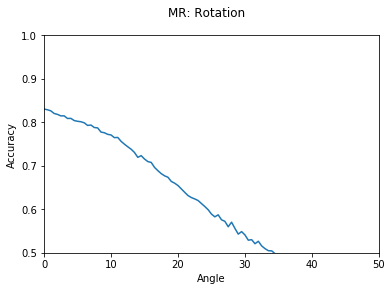

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.axis([0, 50, 0.5, 1])
plt.plot(np.arange(0,50,0.5),accMat)
plt.xlabel("Angle")
plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

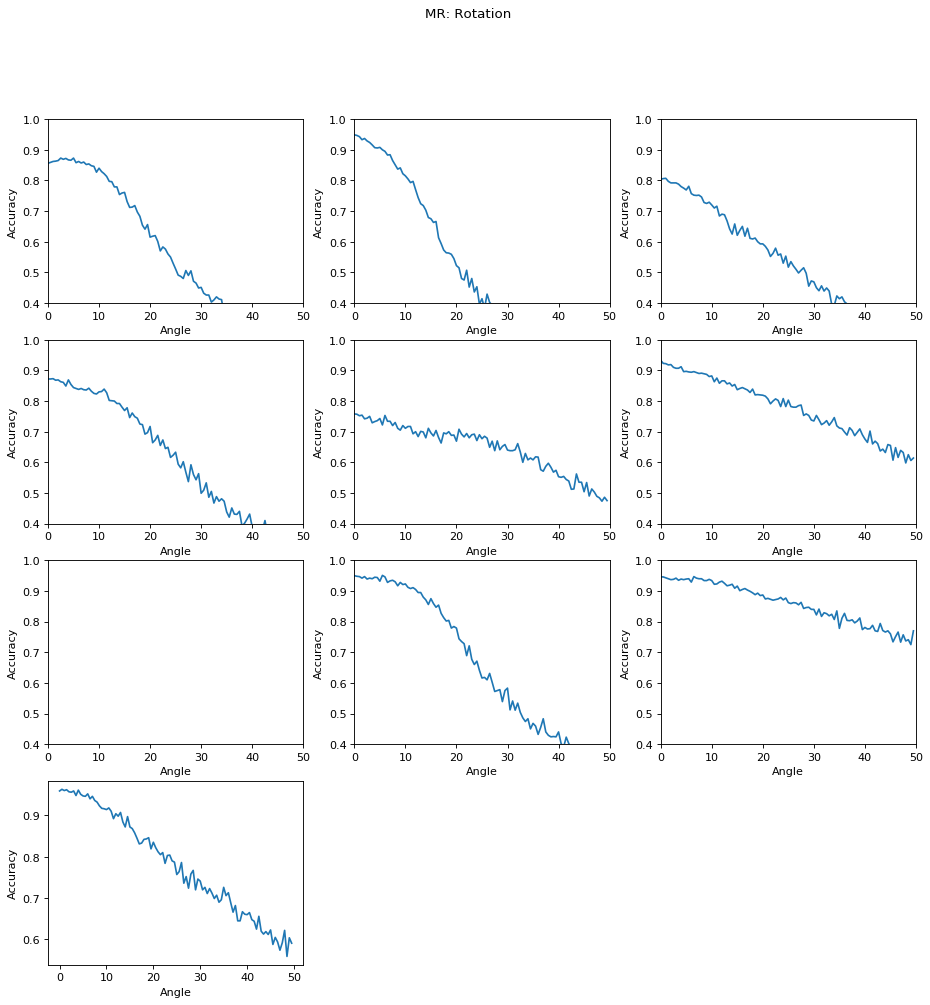

In [12]:
figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(10):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])    
    plt.axis([0, 50, 0.4, 1])
    plt.subplot(4,3,j+1)
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy")
    
plt.suptitle("MR: Rotation")
plt.show()

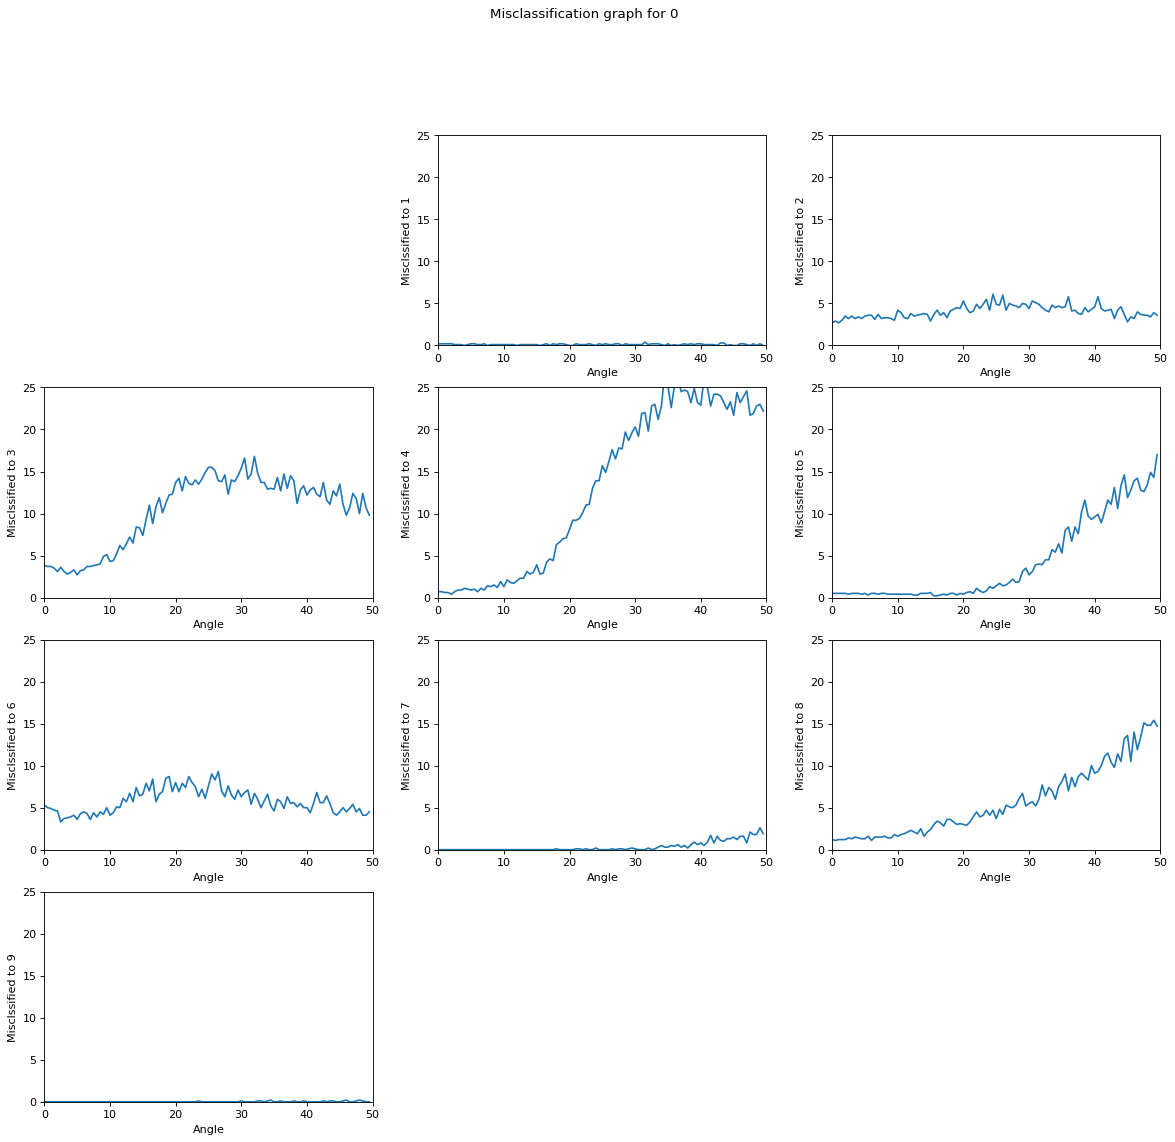

---------------------------------------------------------------------------------------------------------------------


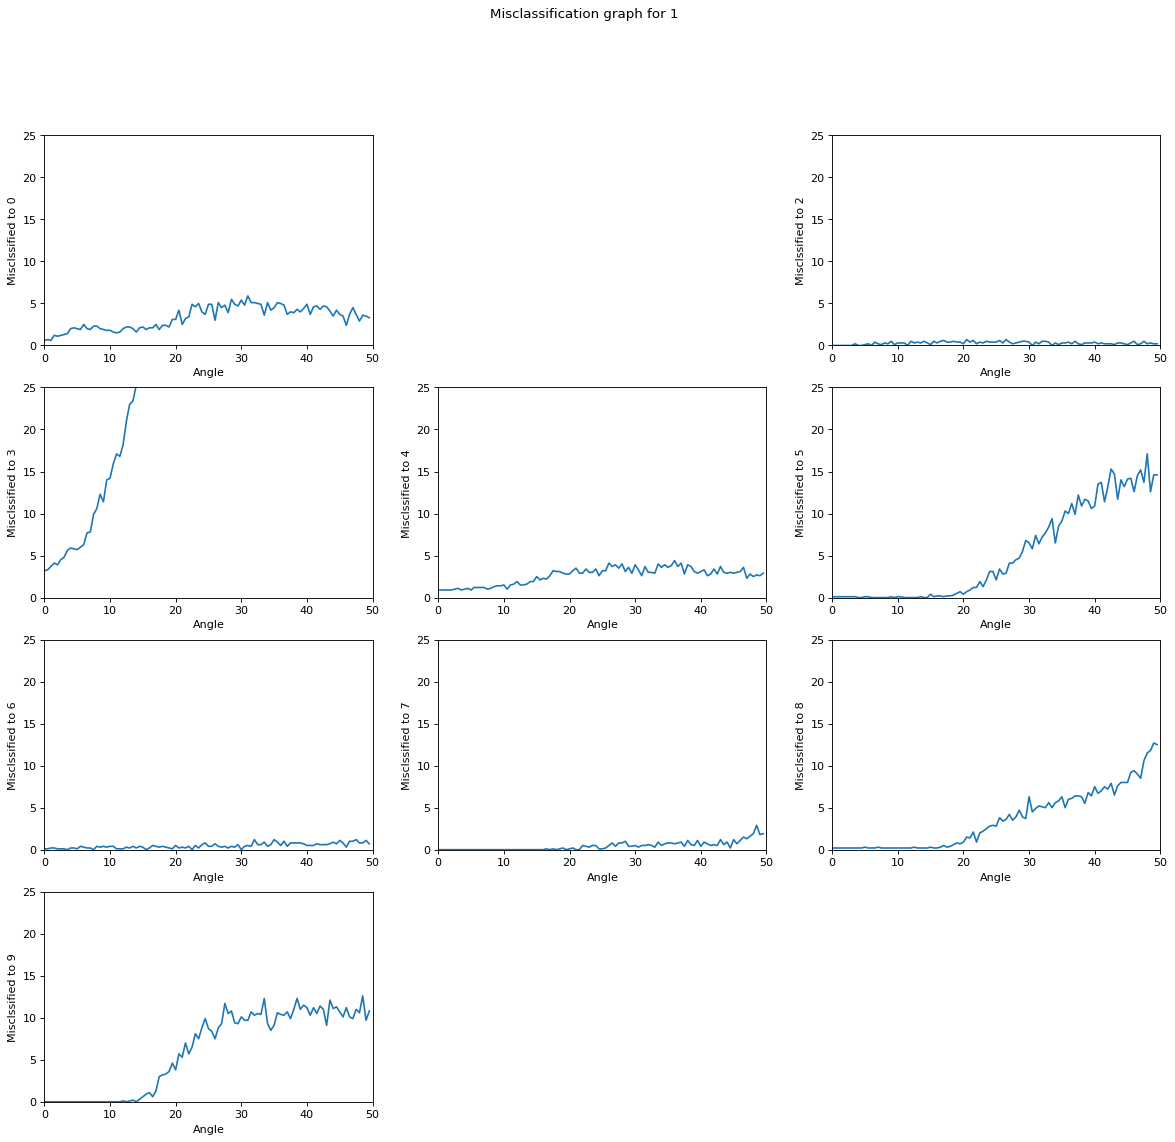

---------------------------------------------------------------------------------------------------------------------


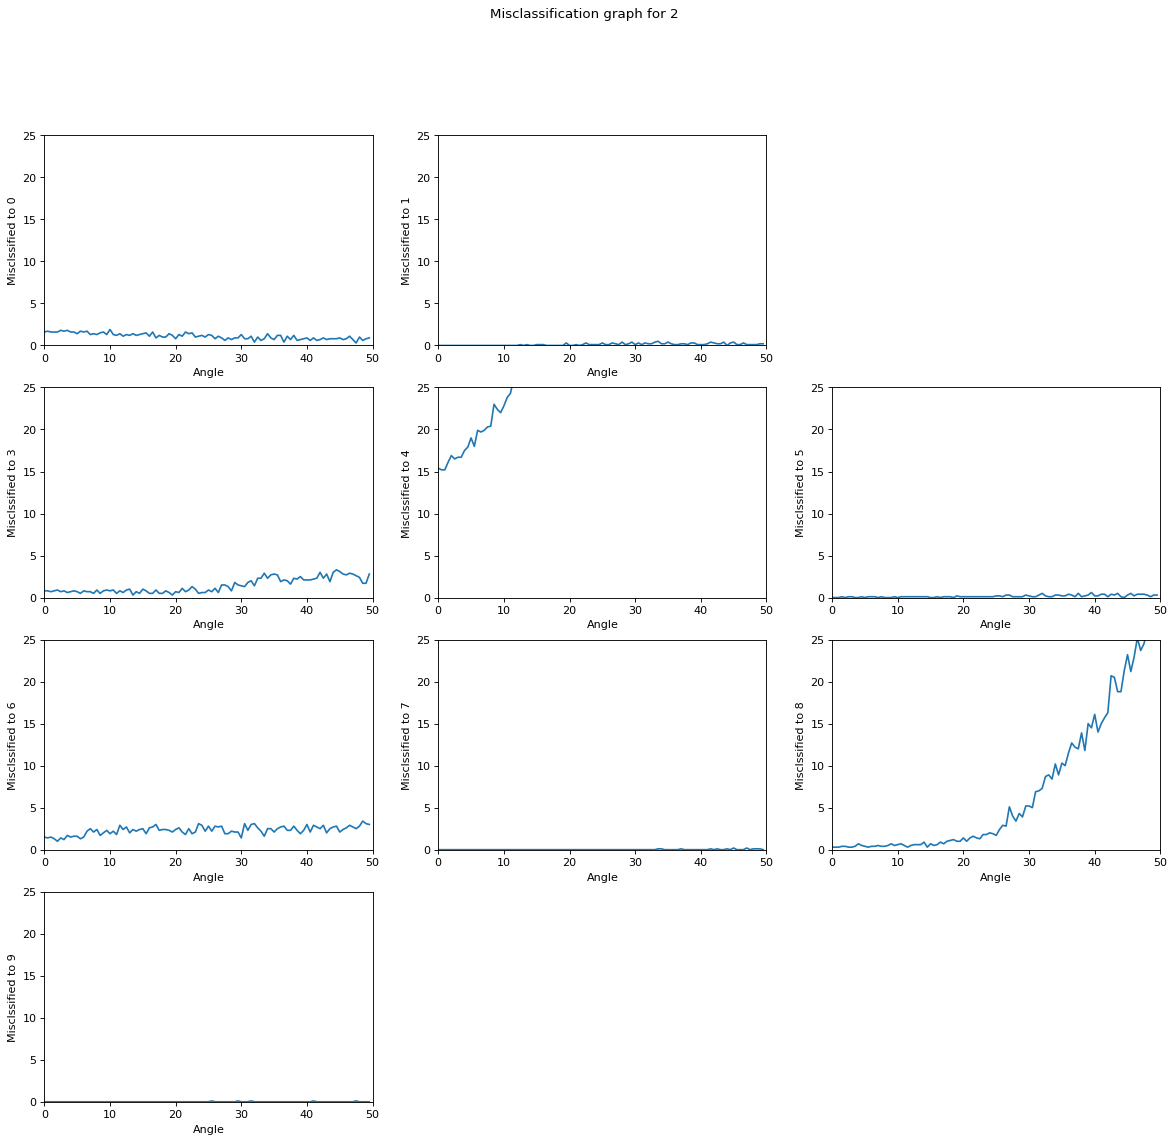

---------------------------------------------------------------------------------------------------------------------


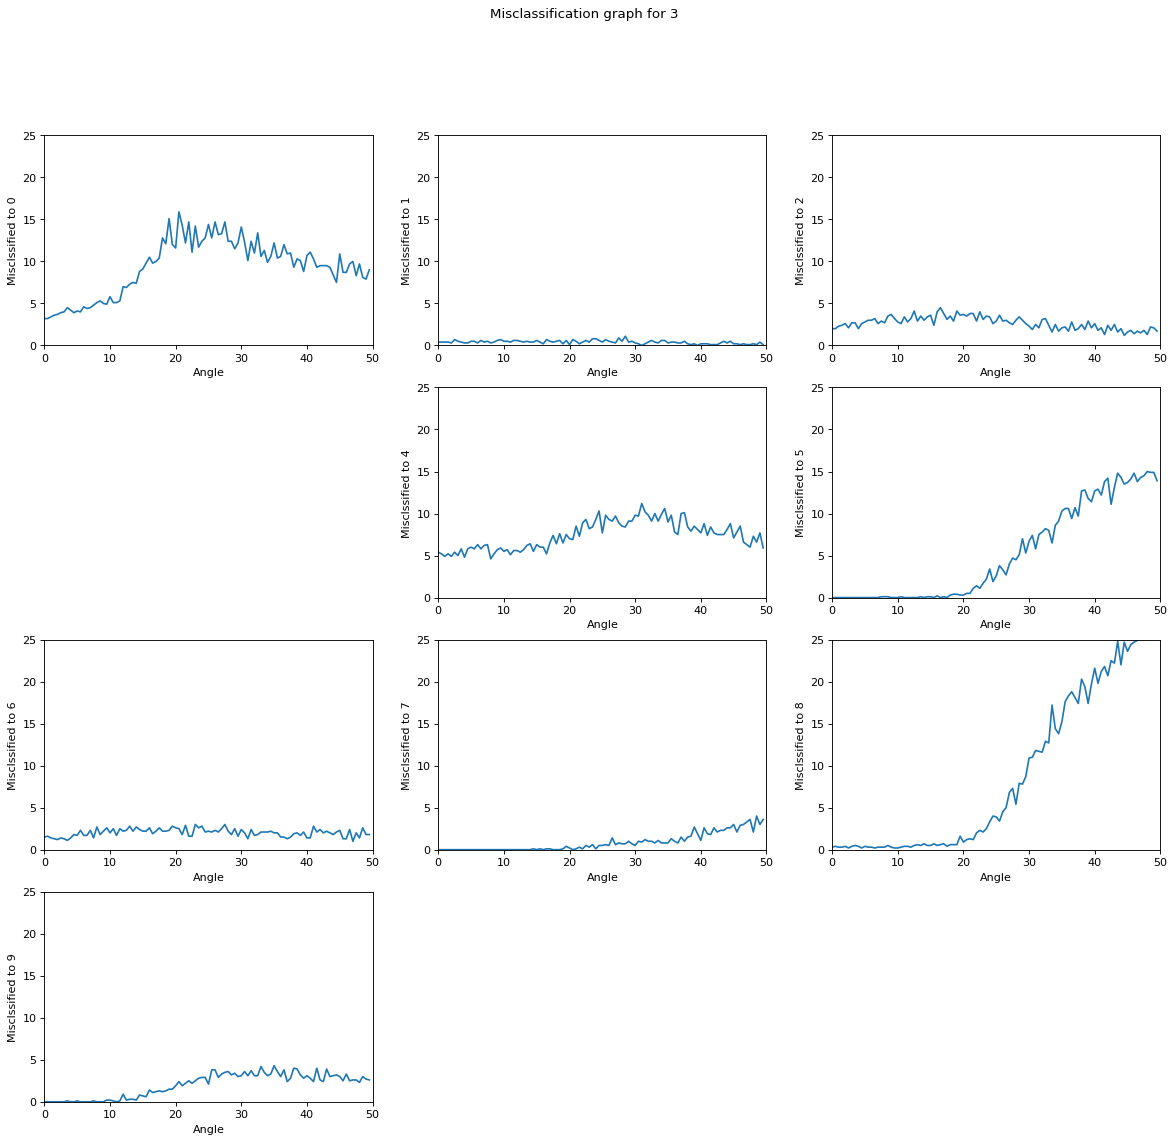

---------------------------------------------------------------------------------------------------------------------


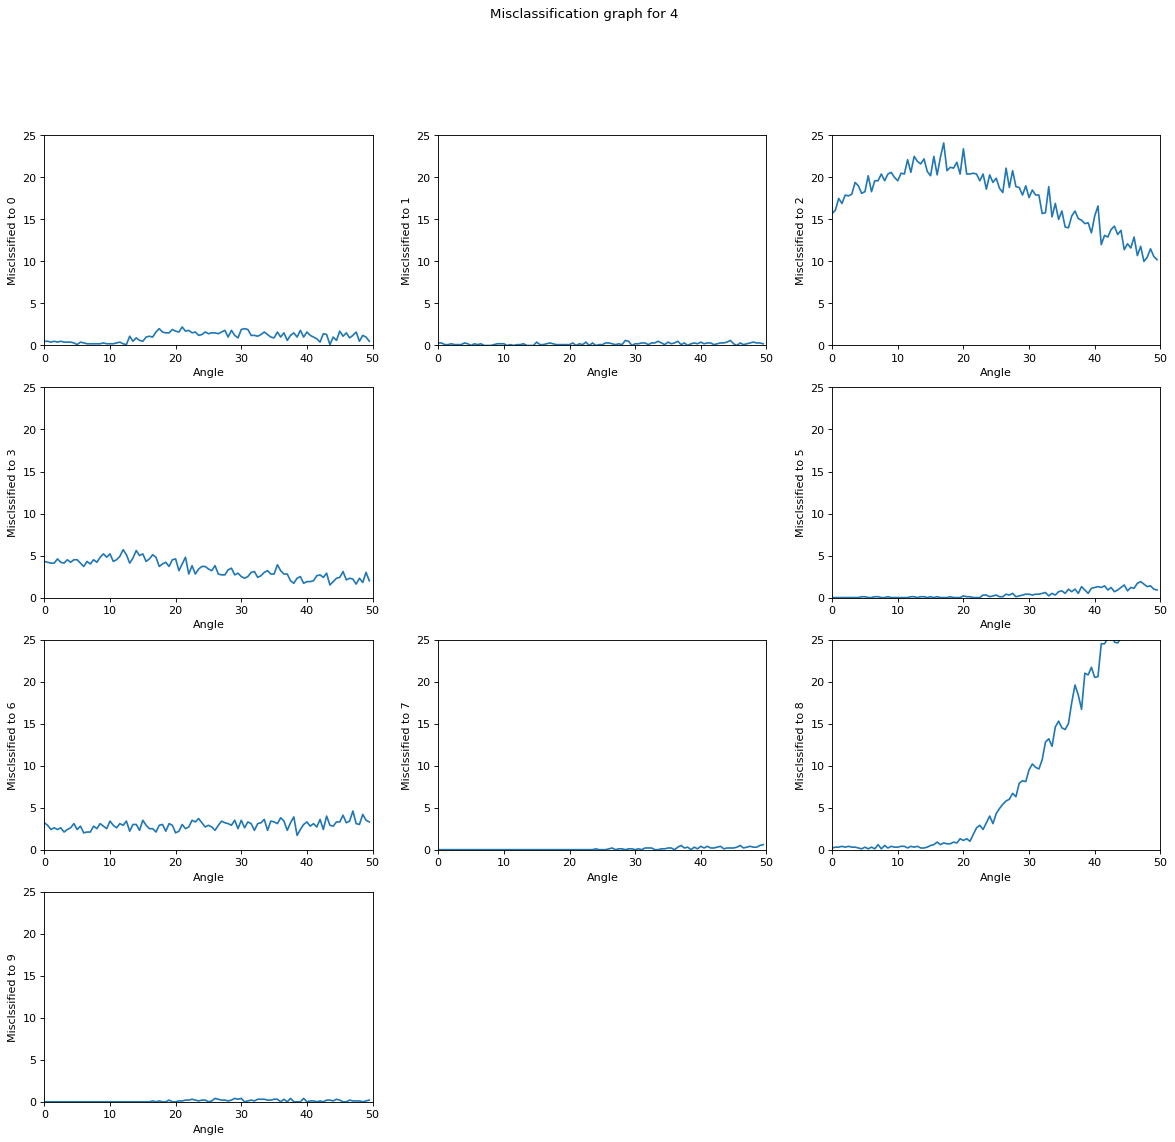

---------------------------------------------------------------------------------------------------------------------


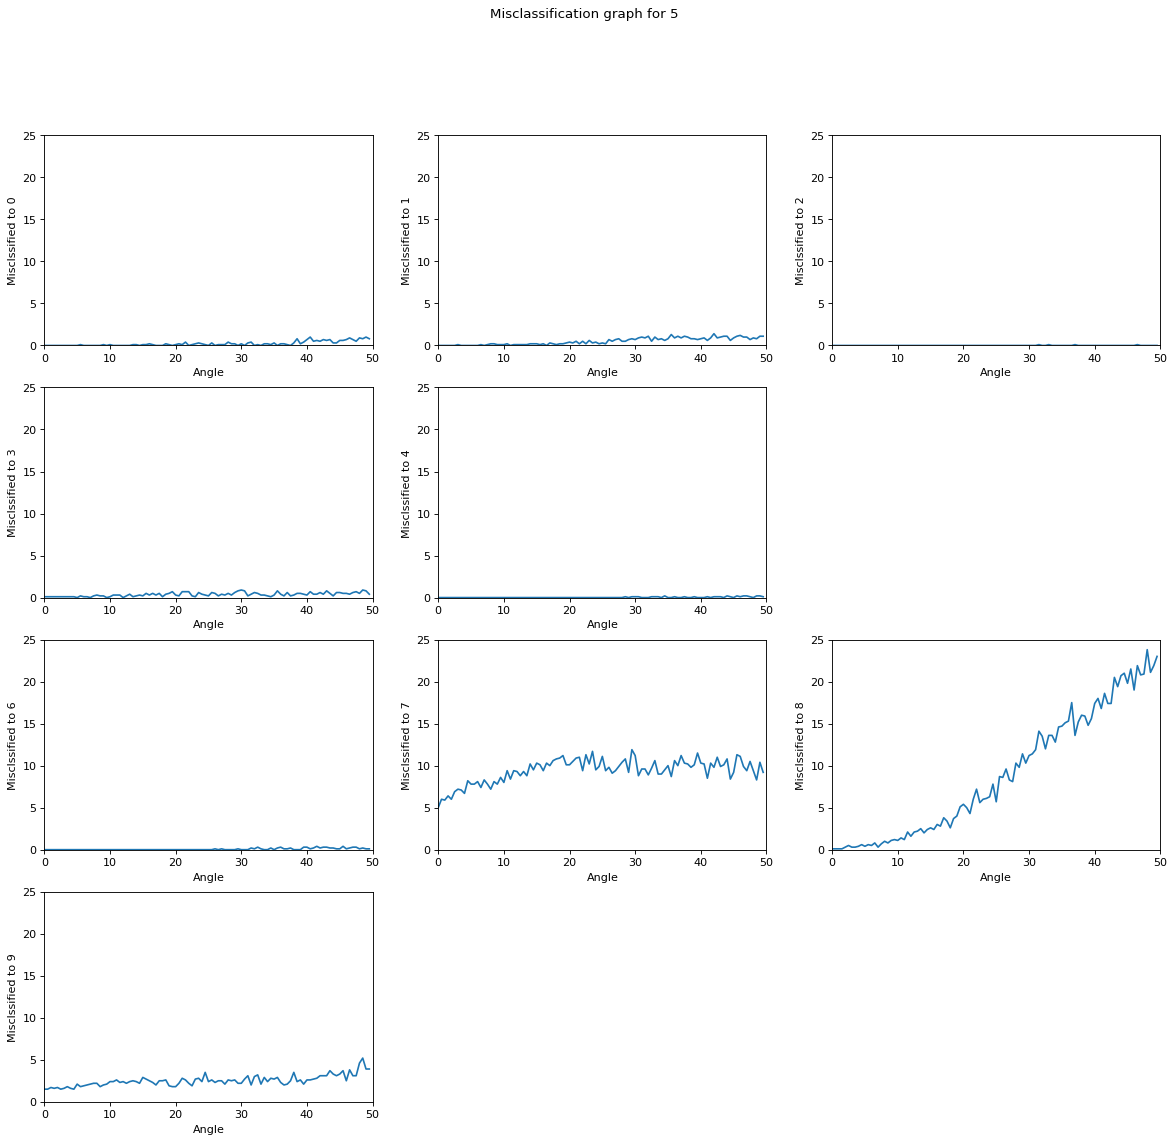

---------------------------------------------------------------------------------------------------------------------


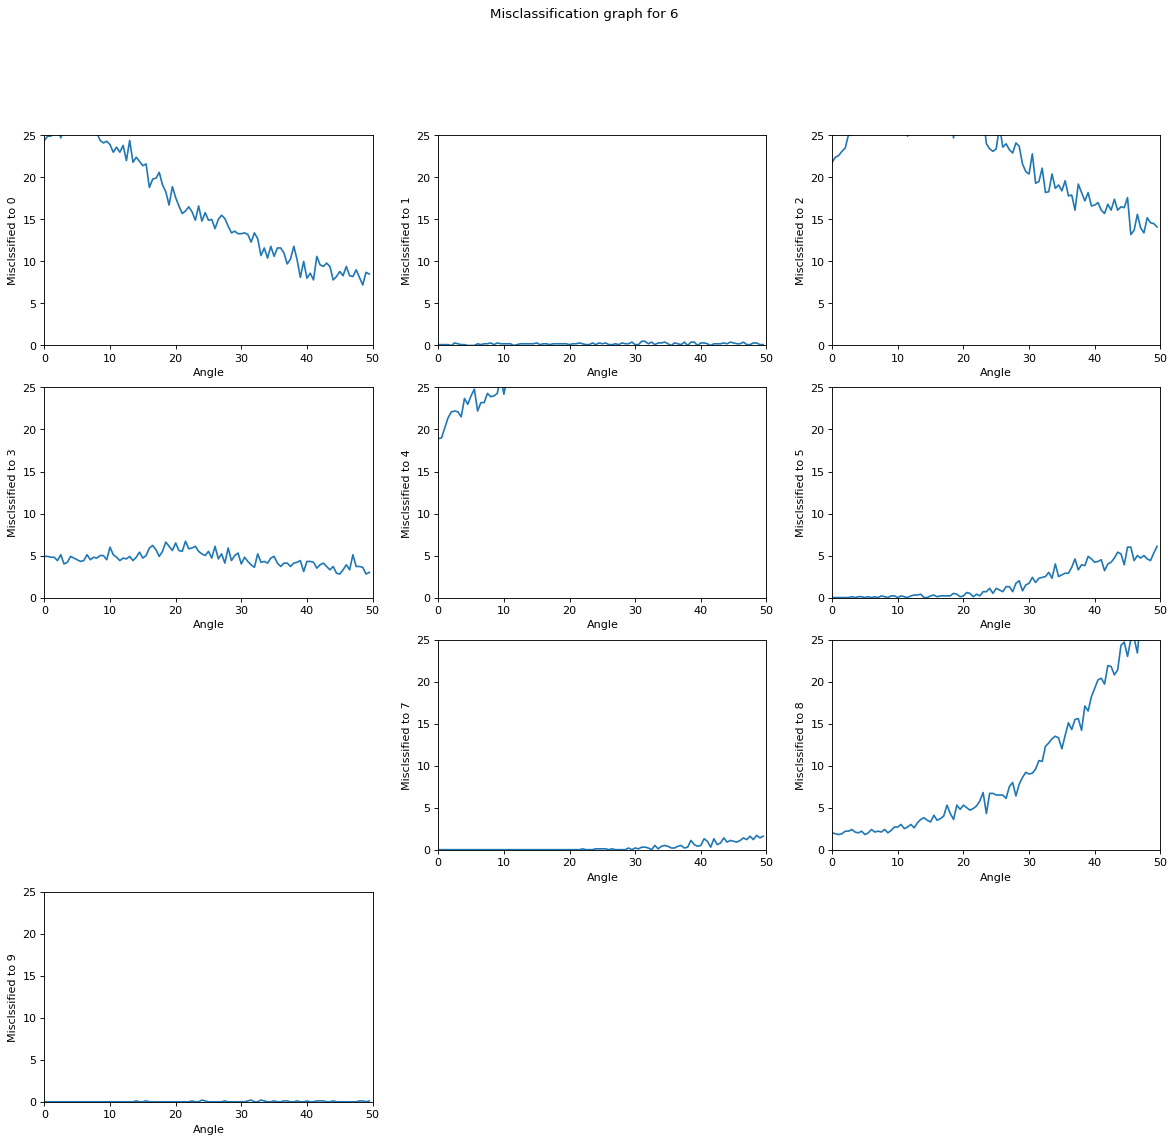

---------------------------------------------------------------------------------------------------------------------


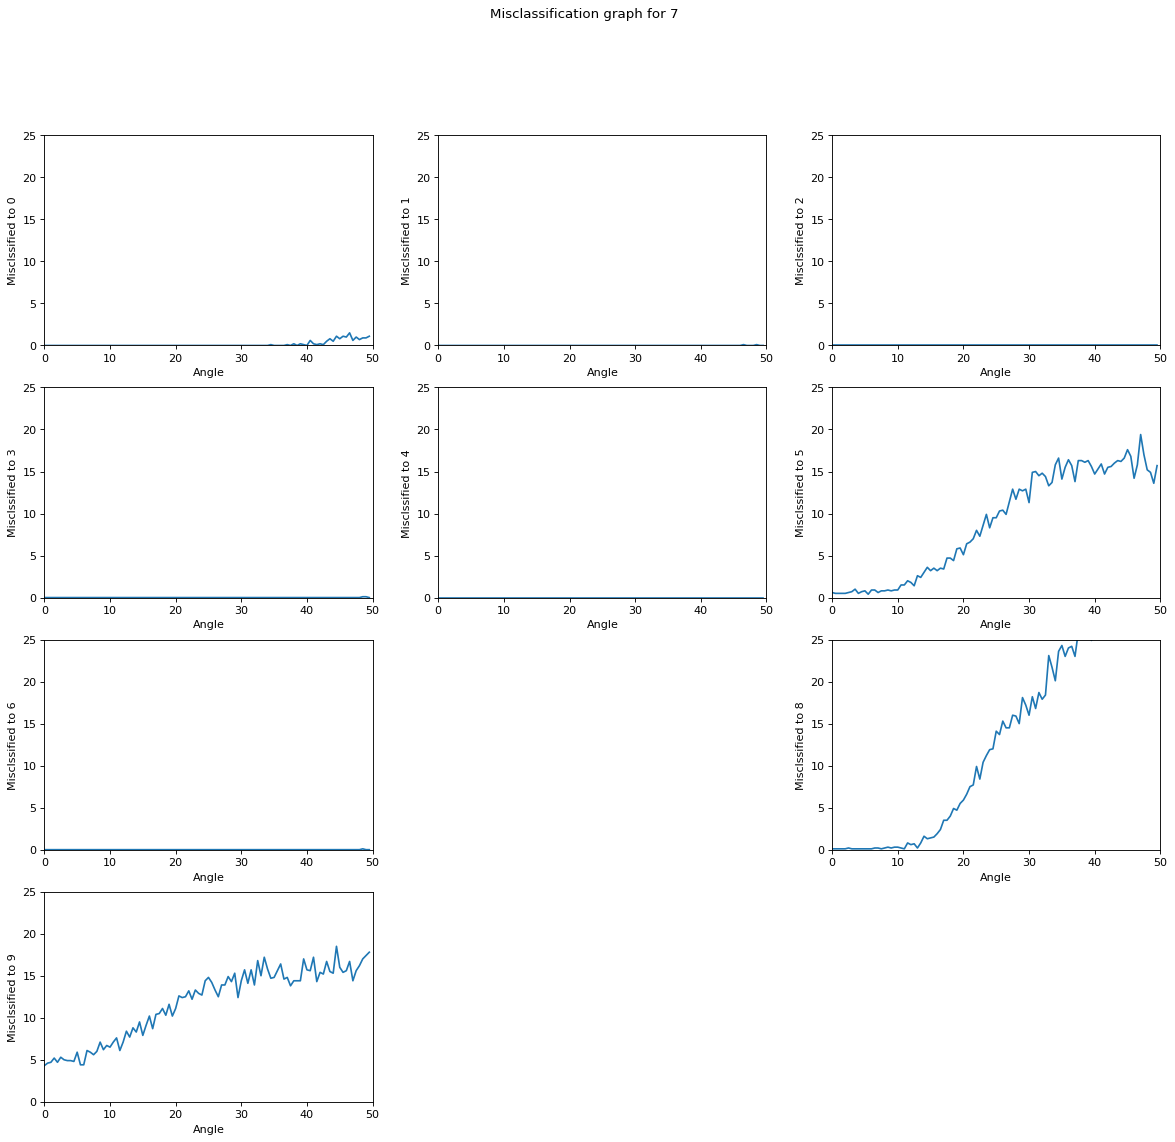

---------------------------------------------------------------------------------------------------------------------


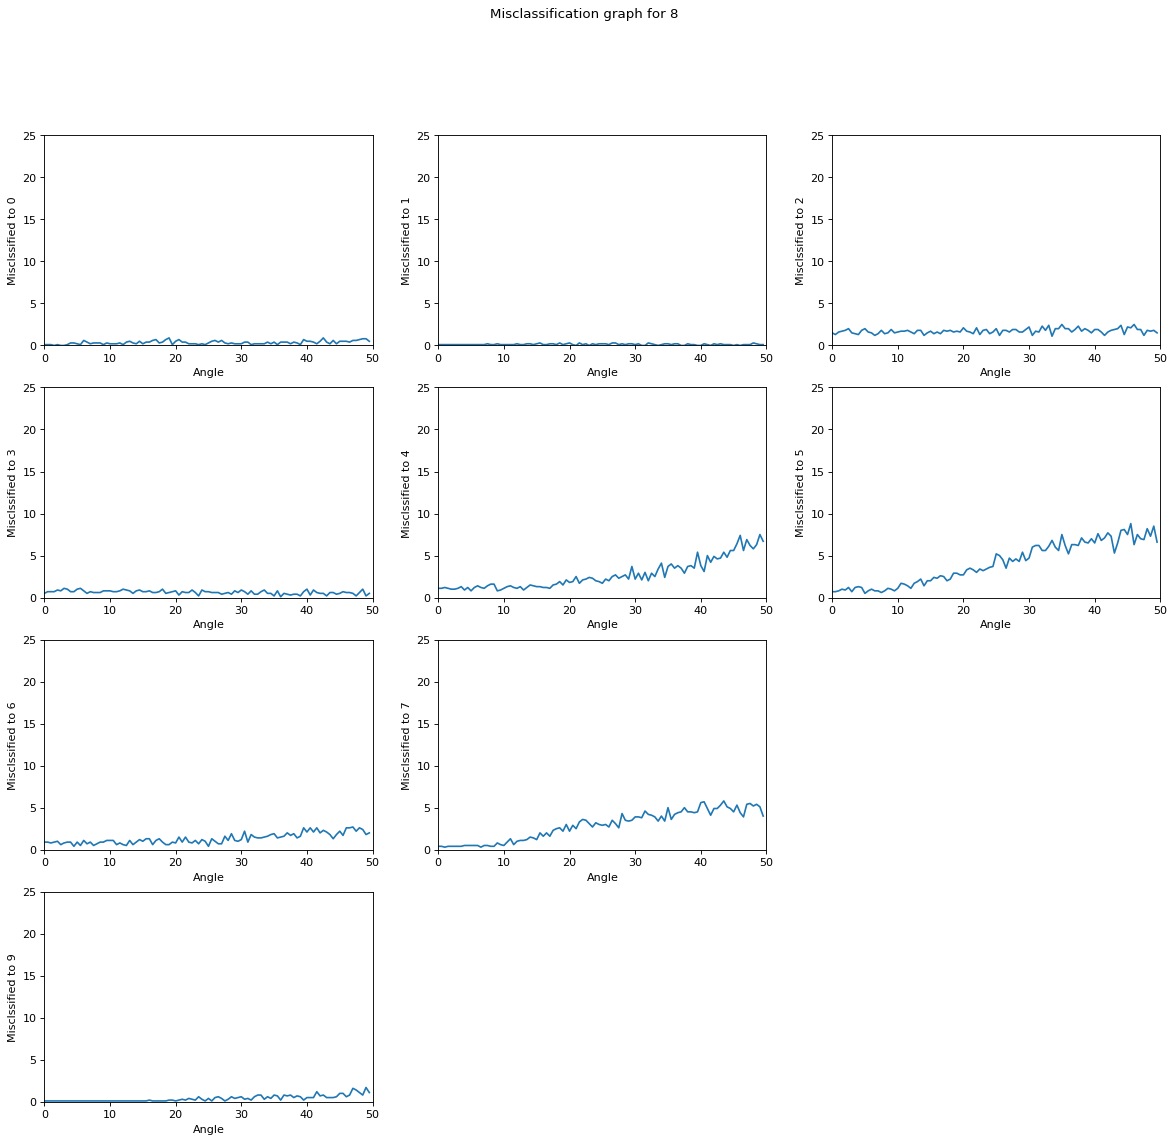

---------------------------------------------------------------------------------------------------------------------


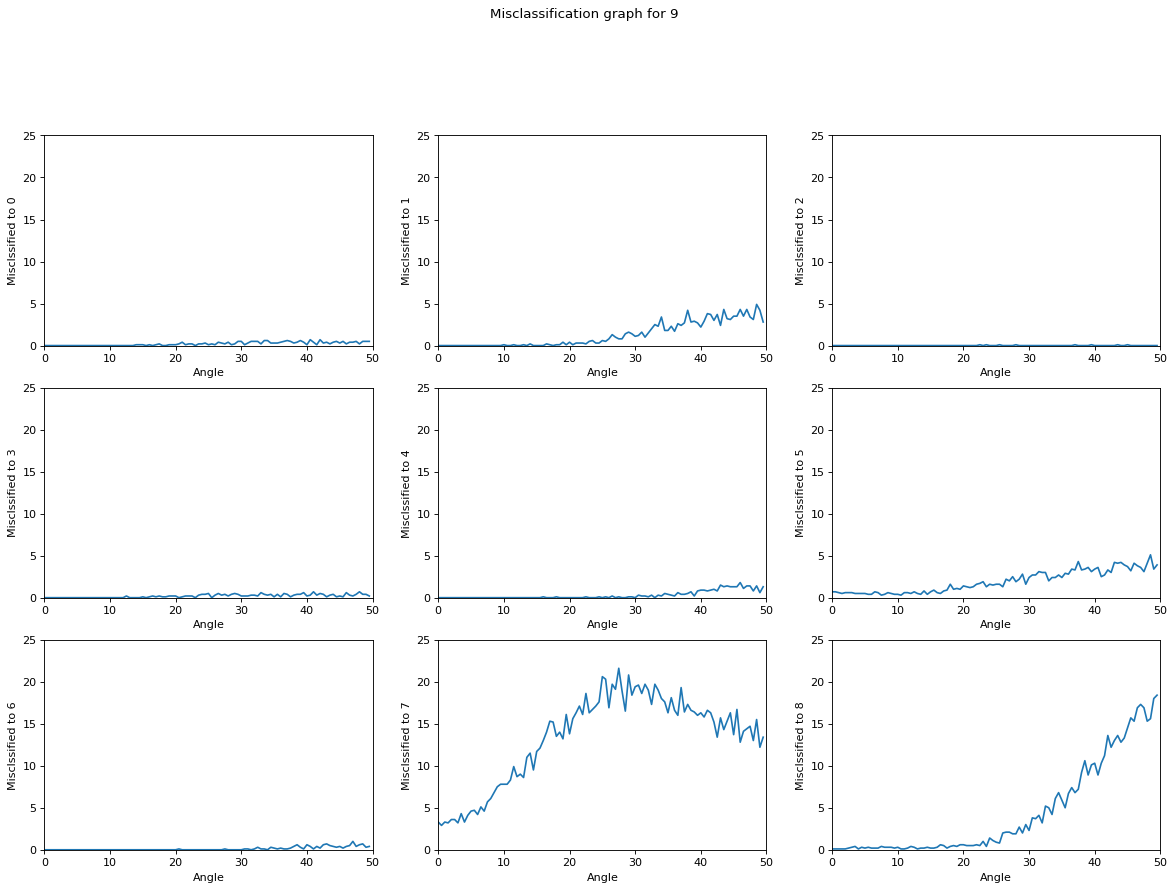

---------------------------------------------------------------------------------------------------------------------


In [13]:
zero = []

for j in range(10):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,10):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k]*100)
        else:
            continue
        plt.subplot(4,3,k+1)
        plt.axis([0, 50, 0,25])
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %str(k))
    plt.suptitle("Misclassification graph for %d" %(j))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")